# fake rates

To account for contamination from QCD processes in the muon plus jet and muon plus hadronic tau selections, it is necessary to resort to data-driven estimates of this background process.  The standard method to do this is to invert the isolation requirement on the muon in these events and scale it based on fake rates measured in a fake enriched control region.  In this case we rely on events originating from Drell-Yan where a jet fakes a muon.  The selection requires the following:

   * single muon trigger with loose track isolation and pt > 25 GeV
   * 2 muons passing tight ID/ISO requirements and consistent with the decay of a Z boson ($75 < M_{\ell\ell} < 115$)
   * one additional muon passing the tight ID, but with no isolation requirement
   * MET < 50 (reduces WZ contamination)

The fake rate is determined as a function of pt and accounts for contamination from processes that give rise to a third prompt muon such as $WZ\rightarrow 3\mu\nu$ and $ZZ\rightarrow 4\mu$.  The fake rate is just the ratio of isolated muons to nonisolations muons:

$$
f = \frac{N_{\mu}(Iso < 0.15)}{N_{\mu}}
$$


In [35]:
# imports and configuration
%cd /home/naodell/work/wbr/analysis

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')

import scripts.plot_tools as pt

/home/naodell/work/wbr/analysis


In [36]:
# Get the data (unbinned)
### get the data and prepare labels
features = ['n_jets', 'n_fwdjets', 'n_bjets', 'n_pu', 'n_pv'
            'lepton1_pt', 'lepton1_eta', 'lepton1_phi', 'lepton1_reliso',              
            'lepton2_pt', 'lepton2_eta', 'lepton2_phi', 'lepton2_reliso',              
            'lepton3_pt', 'lepton3_eta', 'lepton3_phi', 'lepton3_reliso',              
            'dilepton1_mass', 'dilepton1_pt', 'dilepton1_eta', 'dilepton1_phi',
            'dilepton1_pt_asym',
            'met_mag', 'met_phi', 'ht_mag', 'ht_phi',
            ]


cuts = 'n_muons == 3 \
        and lepton1_q != lepton2_q \
        and abs(dilepton1_mass - 91) < 15'

datasets    = [
               'muon_2016B', 'muon_2016C', 'muon_2016D',
               'muon_2016E', 'muon_2016F', 'muon_2016G', 'muon_2016H',
               'zjets_m-50', 'ttbar_lep', 'ttbar_semilep', 'wz_3lnu', 'zz_4l'
               ] 

dm = pt.DataManager(input_dir     = 'data/flatuples/fakes_2016',
                    dataset_names = datasets,
                    selection     = 'fakes',
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = cuts
                   )

Loading dataframes: 100%|███████████████| 12.0/12.0 [00:01<00:00, 10.1it/s]


### WZ control region

The assumed cross-section for the $WZ\rightarrow 3\ell\nu$ is assumed to be 4.4 pb.  To verify this normalization we construct a WZ enriched control region with the following requirements:

   * third muon $p_{T} > 20$
   * third muon $Iso/p_{T} < 0.15$
   * $M_{\mu\mu\mu} > 175$
   * $N_{b tag} = 0$
   
From this region, we derive a correction factor for the WZ MC sample to be used for the background subtraction in the fake enriched region.

In [37]:
# wz control region
wz_cuts = 'lepton3_pt > 20 \
           and lepton3_reliso < 0.15 \
           and dilepton_probe_mass > 200 \
           and n_bjets == 0'
table = dm.print_yields(['ttbar', 'zjets', 'zz_4l', 'wz_3lnu', 'data'], conditions=[wz_cuts])
yields = table['condition_1']
wz_corr = (yields['data'] - yields[['ttbar', 'zjets', 'zz_4l']].sum())/yields['wz_3lnu']

pd.set_option('precision', 1)
print(f'k_wz = {wz_corr}')
table

k_wz = 1.2494626177078323


,condition_1,error_1
ttbar,19.1,0.9
zjets,47.1,14.2
zz_4l,68.6,0.6
wz_3lnu,570.0,6.8
data,847.0,29.1
background,704.8,15.8


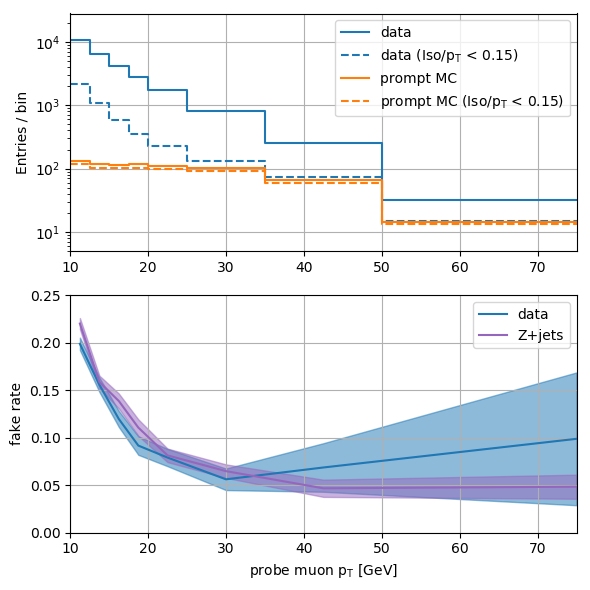

In [38]:
df_data = dm.get_dataframe('data').query('dilepton_probe_mass < 200')
df_bg   = dm.get_dataframes(['wz_3lnu', 'zz_4l'], concat=True).query('dilepton_probe_mass < 200')
df_data_tight = df_data.query('lepton3_reliso < 0.15')
df_bg_tight = df_bg.query('lepton3_reliso < 0.15')

bins = np.array([10., 12.5, 15., 17.5, 20., 25., 35., 50., 100.])
dx = (bins[1:] - bins[:-1])/2
x = bins[:-1] + dx

denom_data, _ = np.histogram(df_data.lepton3_pt, bins) 
denom_bg, _   = np.histogram(df_bg.lepton3_pt, bins, weights=df_bg.weight*wz_corr)
numer_data, _ = np.histogram(df_data_tight.lepton3_pt, bins) 
numer_bg, _   = np.histogram(df_bg_tight.lepton3_pt, bins, weights=df_bg_tight.weight*wz_corr)
f = (numer_data - numer_bg)/(denom_data - denom_bg)

denom_bg_var, _   = np.histogram(df_bg.lepton3_pt, bins, weights=(df_bg.weight*wz_corr)**2)
numer_bg_var, _   = np.histogram(df_bg_tight.lepton3_pt, bins, weights=(df_bg_tight.weight*wz_corr)**2)
denom_err = np.sqrt(denom_data + denom_bg_var)
numer_err = np.sqrt(numer_data + numer_bg_var)
err = pt.ratio_errors(numer_data - numer_bg, numer_err, denom_data - denom_bg, denom_err)

df_zjets = dm.get_dataframe('zjets')
denom, _ = np.histogram(df_zjets.lepton3_pt, bins, weights=df_zjets.weight)
numer, _ = np.histogram(df_zjets.query('lepton3_reliso < 0.15').lepton3_pt, bins, weights=df_zjets.query('lepton3_reliso < 0.15').weight)
f_true = numer/denom 
err_true = np.sqrt(f_true*(1-f_true)/denom)

fig, axes = plt.subplots(2, 1, figsize=(6, 6), facecolor='white', sharex=False, gridspec_kw={'height_ratios':[1,1]})
fig.subplots_adjust(hspace=0)

denom_data = np.append(denom_data/dx, denom_data[-1]/dx[-1])
denom_bg = np.append(denom_bg/dx, denom_bg[-1]/dx[-1])
numer_data = np.append(numer_data/dx, numer_data[-1]/dx[-1])
numer_bg = np.append(numer_bg/dx, numer_bg[-1]/dx[-1])

axes[0].plot(bins, denom_data, color='C0', drawstyle='steps-post') 
axes[0].plot(bins, numer_data, color='C0', linestyle='--', drawstyle='steps-post') 
axes[0].plot(bins, denom_bg, color='C1', drawstyle='steps-post')
axes[0].plot(bins, numer_bg, linestyle='--', color='C1', drawstyle='steps-post')

axes[0].set_ylabel('Entries / bin')
axes[0].set_yscale('log')
axes[0].set_ylim(5, 2.5*denom.max())
axes[0].set_xlim(bins[0], bins[-1] - dx[-1])
axes[0].legend(['data', r'data (Iso/$\sf p_{T}$ < 0.15)', 'prompt MC', r'prompt MC (Iso/$\sf p_{T}$ < 0.15)'])
axes[0].grid()

axes[1].plot(x, f)
axes[1].fill_between(x, f+1.5*err, f-1.5*err, color='C0', alpha=0.5,)
axes[1].plot(x, f_true, c='C4')
axes[1].fill_between(x, f_true+1.5*err_true, f_true-1.5*err_true, color='C4', alpha=0.5,)
axes[1].set_xlabel(r'probe muon $\sf p_{T}$ [GeV]')
axes[1].set_ylabel('fake rate')
axes[1].set_xlim(bins[0], bins[-1] - dx[-1])
axes[1].set_ylim(0., 0.25)
axes[1].grid()
axes[1].legend(['data', 'Z+jets'])

plt.tight_layout()
plt.savefig('plots/fake_rates.pdf')
plt.show()